<a href="https://colab.research.google.com/github/ykitaguchi77/Kaggle/blob/main/RSNA_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Kaggle_spine EfficientNet baseline**

https://www.kaggle.com/code/thedevastator/tf-rsna-efficient-net-baseline

In [ ]:
!pip install path
!pip install pydicom
import os
import cv2
import glob
import traceback
import cv2 as cv
import numpy as np
import pandas as pd
from path import Path
from tqdm import tqdm
import nibabel as nib
import pydicom as dicom
import tensorflow as tf
from keras import layers
from pydicom import dcmread
from tensorflow import keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from pydicom.data import get_testdata_files
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import os
import gc
import cv2
import copy
import time
import random
import string
import joblib
import tifffile
import numpy as np 
import pandas as pd 
import torch
from torch import nn
import seaborn as sns
import pydicom as dicom
from torchvision import models
from scipy.special import expit
from pydicom import dcmread
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.optim import lr_scheduler
import warnings
warnings.filterwarnings("ignore")

#Gdriveをマウント
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/Kaggle/rsna-2022-cervical-spine-fracture-detection") #親フォルダ


In [21]:
bad = np.array([['1.2.826.0.1.3680043.10197_C1', '1.2.826.0.1.3680043.10197','C1'],['1.2.826.0.1.3680043.10454_C1', '1.2.826.0.1.3680043.10454','C1'],['1.2.826.0.1.3680043.10690_C1', '1.2.826.0.1.3680043.10690','C1']], dtype=np.object)

debug = False
train_df = pd.read_csv("./train.csv").head(10000)
test_df = pd.read_csv("./test.csv")
if(test_df.values[0][0] == bad[0][0]):
    test_df = pd.DataFrame({"row_id": ['1.2.826.0.1.3680043.22327_C1', '1.2.826.0.1.3680043.25399_C1', '1.2.826.0.1.3680043.5876_C1'],
                           "StudyInstanceUID": ['1.2.826.0.1.3680043.22327', '1.2.826.0.1.3680043.25399', '1.2.826.0.1.3680043.5876'],
                           "prediction_type": ["C1", "C1", "C1"]})
dirs = ["./train_images",  "./test_images"]
means = list(train_df.mean(numeric_only=True).to_dict().values())
test_df


,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.22327_C1,1.2.826.0.1.3680043.22327,C1
1,1.2.826.0.1.3680043.25399_C1,1.2.826.0.1.3680043.25399,C1
2,1.2.826.0.1.3680043.5876_C1,1.2.826.0.1.3680043.5876,C1


In [3]:
def load_dicom(path, size = 64):
    try:
        img=dicom.dcmread(path)
        img.PhotometricInterpretation = 'YBR_FULL'
        data=img.pixel_array
        data=data-np.min(data)
        if np.max(data) != 0:
            data=data/np.max(data)
        data=(data*255).astype(np.uint8)        
        return cv2.cvtColor(data.reshape(512, 512), cv2.COLOR_GRAY2RGB)
    except:        
        return np.zeros((512, 512, 3))

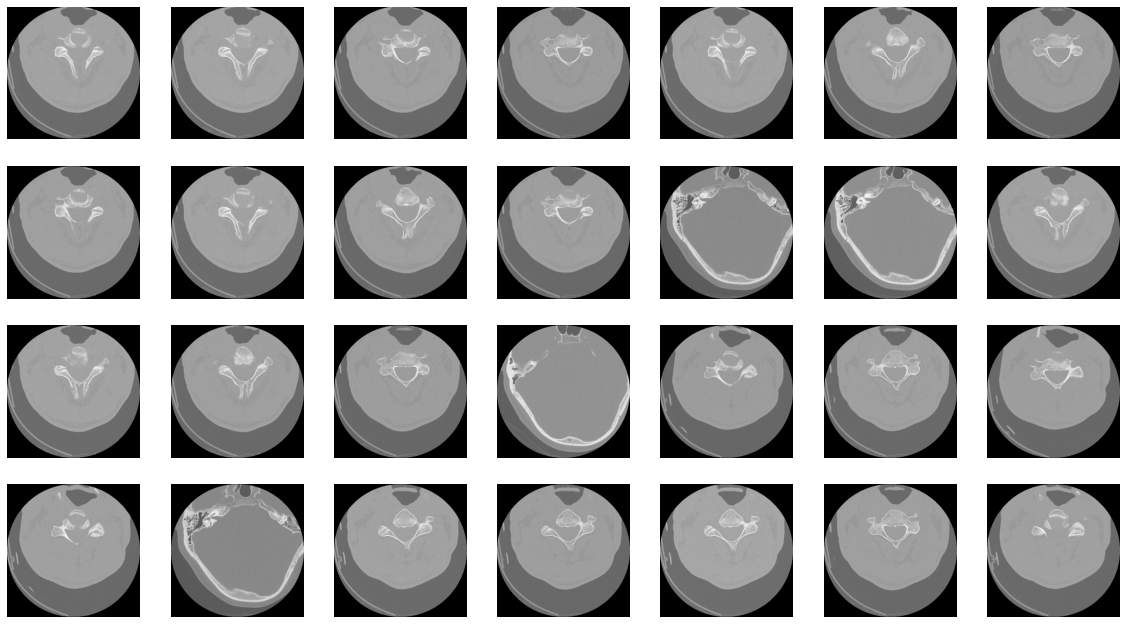

In [4]:
image_file = glob.glob("./train_images/1.2.826.0.1.3680043.10001/*.dcm")
plt.figure(figsize=(20, 20))

for i in range(28):
    ax = plt.subplot(7, 7, i + 1)
    image_path = image_file[i]
    image = load_dicom(image_path)
    plt.axis('off')   
    plt.imshow(image)

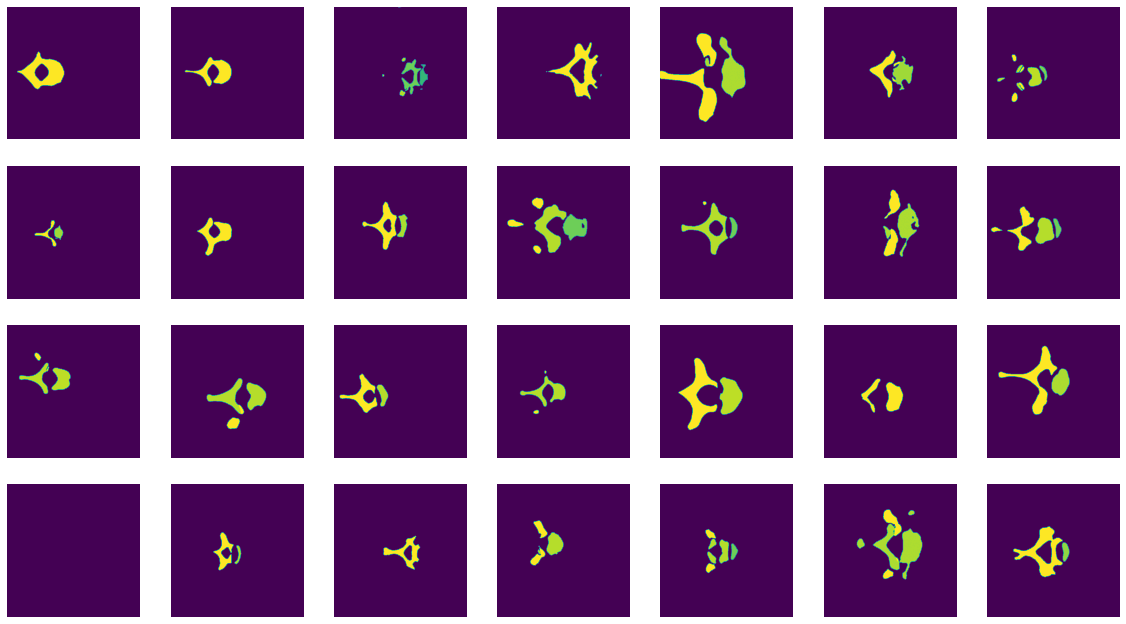

In [5]:
image_file = glob.glob("./segmentations/*.nii")
plt.figure(figsize=(20, 20))

for i in range(28):
    ax = plt.subplot(7, 7, i + 1)
    image_path = image_file[i]
    nii_img = nib.load(image_path).get_fdata()
    nib_image = nii_img[:,:,59]
    plt.axis('off')
    plt.imshow(nib_image)

In [22]:
class ImgDataset(Dataset):
    def __init__(self, df, max_images = 10):
        self.df = df 
        self.train = 'patient_overall' in df.columns
        self.imgs = []
        self.labels = []
        self.ids = []
        self.prediction_type = []
        for i in range(self.df.shape[0]):
            lst = os.listdir(os.path.join(dirs[1-self.train], self.df.StudyInstanceUID.values[i]))
            random.shuffle(lst)
            for im in lst[:max_images]:
                self.prediction_type.append(["patient_overall", "C1", "C2", "C3", "C4", "C5", "C6", "C7"].index(self.df.prediction_type.values[i]))
                if(not self.train):
                    self.ids.append(self.df.row_id.values[i])
                self.imgs.append(os.path.join(dirs[1-self.train], self.df.StudyInstanceUID.values[i], im))
                if(self.train):
                    self.labels.append(self.df.drop(["StudyInstanceUID"], axis = 1).iloc[i].values)
                else:
                    self.labels.append([0]*8)
            del lst
            gc.collect()
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        image = load_dicom(self.imgs[index])
        label = self.labels[index]
        gc.collect()
        return image, label, self.ids[index], self.prediction_type[index]

In [43]:
train_df

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.21684,1,0,1,0,0,0,1,1
2015,1.2.826.0.1.3680043.4786,1,0,0,0,0,0,0,1
2016,1.2.826.0.1.3680043.14341,0,0,0,0,0,0,0,0
2017,1.2.826.0.1.3680043.12053,0,0,0,0,0,0,0,0


In [23]:
def predict(model, dataloader):
    model.cuda()
    model.eval()
    dataloader = dataloader
    outputs = []
    ids = []
    for item in tqdm(dataloader, leave=False): #tqdm: プログレスバー
        patient_id = item[2][0]
        try:
            images = item[0].cuda().float()
            ids.append(patient_id)
            output = model(images)
            outputs.append(((output.cpu()[0].detach().numpy()).astype(float)[item[3]]))
        except:
            outputs.append(means[item[3]])
    return np.array([min(1,max(i, 0)) for i in outputs]), ids

In [35]:
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=False, num_classes = 8)
batch_size = 1
test_loader = DataLoader(
    ImgDataset(test_df), 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=1
)
criterion = nn.CrossEntropyLoss()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [36]:
pr = predict(model, test_loader)


  0%|          | 0/30 [00:00<?, ?it/s]

In [47]:
pr[0]

array([0.07231303, 0.07231303, 0.07231303, 0.07231303, 0.07231303,
       0.07231303, 0.07231303, 0.07231303, 0.07231303, 0.07231303,
       0.07231303, 0.07231303, 0.07231303, 0.07231303, 0.07231303,
       0.07231303, 0.07231303, 0.07231303, 0.07231303, 0.07231303,
       0.07231303, 0.07231303, 0.07231303, 0.07231303, 0.07231303,
       0.07231303, 0.07231303, 0.07231303, 0.07231303, 0.07231303])

In [66]:
pr = pd.DataFrame({"row_id" : pr[1], "fractured" : pr[0]}).groupby("row_id").mean()


KeyError: ignored

In [64]:
submission = pd.read_csv("./sample_submission.csv")
submission.fractured = pr.fractured.to_list()


In [63]:
submission

,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.072313
1,1.2.826.0.1.3680043.10454_C1,0.072313
2,1.2.826.0.1.3680043.10690_C1,0.072313


#**RSNA EfficientNet (train)**

https://www.kaggle.com/code/rhadleyools/rsna-efficientnet-train

In [2]:
! pip install pylibjpeg
! pip install python-gdcm
! pip install pylibjpeg-libjpeg
! pip install torchsummary
! pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 6.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 8.2 MB/s 


In [3]:
import os
import gc
import cv2
import copy
import time
import gdcm
import random
import string
import joblib
import tifffile
import pylibjpeg
import numpy as np 
import pandas as pd 
import torch
from torch import nn
import seaborn as sns
import pydicom as dicom
from torchvision import models
from pydicom import dcmread
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.optim import lr_scheduler
import warnings
warnings.filterwarnings("ignore")

#Gdriveをマウント
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/Kaggle/rsna-2022-cervical-spine-fracture-detection") #親フォルダ

Mounted at /content/drive


In [4]:
debug = False
train_df = pd.read_csv("./train.csv").head(10 if debug else 100)
test_df = pd.read_csv("./test.csv")
dirs = ["./train_images",  "./test_images"]
train_df
#train_df.describe()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
95,1.2.826.0.1.3680043.24289,0,0,0,0,0,0,0,0
96,1.2.826.0.1.3680043.22006,1,0,0,0,0,0,0,1
97,1.2.826.0.1.3680043.11254,1,0,0,0,0,0,0,1
98,1.2.826.0.1.3680043.9940,1,0,0,0,1,1,0,0


In [5]:
def load_dicom(path, size = 512):
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data=img.pixel_array
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)
    gc.collect()
    return cv2.cvtColor(data.reshape(512,512), cv2.COLOR_GRAY2RGB).transpose(2,0,1)

In [6]:
class ImgDataset(Dataset):
    def __init__(self, df, max_images = 10):
        self.df = df 
        self.train = 'patient_overall' in df.columns
        self.imgs = []
        self.labels = []
        for i in range(self.df.shape[0]): #rows
            try: #listのtrain_imageが無かった場合は飛ばす　(※datasetが大きすぎてgdriveに移行しきれていないため)
                lst = os.listdir(os.path.join(dirs[0], self.df.StudyInstanceUID.values[i])) #画像フォルダのパス
                random.shuffle(lst)
                for im in lst[:max_images]:
                    self.imgs.append(os.path.join(dirs[0], self.df.StudyInstanceUID.values[i], im)) #train_images内の画像毎のパス
                    if(self.train):
                        self.labels.append(self.df.drop(["StudyInstanceUID"], axis = 1).iloc[i].values) #ラベルをdfからリスト化
                    else:
                        self.labels.append(None)
                del lst
            except: pass
            gc.collect()
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        image = load_dicom(self.imgs[index])
        label = self.labels[index]
        gc.collect()
        return image, label

In [ ]:
d = ImgDataset(train_df)
d.__getitem__(0)[0].shape


In [ ]:
with open("best_score.txt", "w") as f:
    f.write("100000")

In [ ]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs):
    with open("best_score.txt", "r") as f:
        best_loss = float(f.read())

    for epoch in range(num_epochs):
        model.cuda()
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_acc = 0
            
            dataloader = dataloaders_dict[phase]
            for item in tqdm(dataloader, leave=False):
                images = item[0].cuda().float()
                classes = item[1].cuda().float()
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(images)
                    loss = criterion(output, classes)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * len(output)
                    epoch_acc += torch.sum((output>0.5) == classes.data)/8
                    gc.collect()

            data_size = len(dataloader.dataset)
            epoch_loss = epoch_loss / data_size
            epoch_acc = epoch_acc.double() / data_size

            print(f'Epoch {epoch + 1}/{num_epochs} | {phase:^5} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')
        
        if epoch_loss < best_loss:
            traced = torch.jit.trace(model, torch.zeros(1, 3, 512, 512).cuda())
            traced.save('model.pth')
            best_loss = epoch_loss
            with open("best_score.txt", "w") as f:
                f.write(str(best_loss))

In [ ]:
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=False, num_classes = 8)
train, val = train_test_split(train_df, test_size=0.2, random_state=42)
batch_size = 1
train_loader = DataLoader(
    ImgDataset(train), 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=1
)
val_loader = DataLoader(
    ImgDataset(val), 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=1
)
dataloaders_dict = {"train": train_loader, "val": val_loader}
criterion = nn.MSELoss()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
train_model(model, dataloaders_dict, criterion, optimizer, 2)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
# train_model(model, dataloaders_dict, criterion, optimizer, 2)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# train_model(model, dataloaders_dict, criterion, optimizer, 2)